In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-dataset/Exogenous_Data_1987_2024.xlsx
/kaggle/input/time-series-dataset/Training_Data_From_2000_To_2023 (1).xlsx


Epoch 1/50
Train Loss: 0.4078727066516876, Test Loss (Backprop): 0.0015961640747264028
Epoch 2/50
Train Loss: 0.10092952847480774, Test Loss (Backprop): 0.00036005250876769423
Epoch 3/50
Train Loss: 0.05769727751612663, Test Loss (Backprop): 0.00020145715097896755
Epoch 4/50
Train Loss: 0.35269057750701904, Test Loss (Backprop): 0.00017759813636075705
Epoch 5/50
Train Loss: 0.3481203317642212, Test Loss (Backprop): 0.00014366379764396697
Epoch 6/50
Train Loss: 0.08967815339565277, Test Loss (Backprop): 0.00011631725647021085
Epoch 7/50
Train Loss: 0.13885413110256195, Test Loss (Backprop): 0.0002816215273924172
Epoch 8/50
Train Loss: 0.2356107532978058, Test Loss (Backprop): 7.61168121243827e-05
Epoch 9/50
Train Loss: 0.14285418391227722, Test Loss (Backprop): 0.00013080841745249927
Epoch 10/50
Train Loss: 0.3221432566642761, Test Loss (Backprop): 6.095880962675437e-05
Epoch 11/50
Train Loss: 0.0419313944876194, Test Loss (Backprop): 5.2492534450720996e-05
Epoch 12/50
Train Loss: 0.260

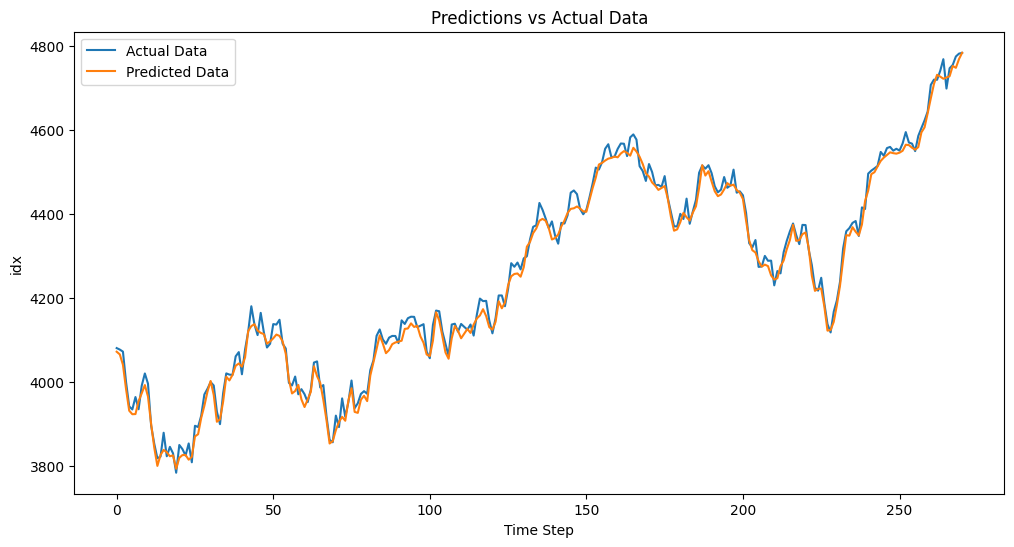

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model

# Load datasets
exogenous_data_path = '/kaggle/input/time-series-dataset/Exogenous_Data_1987_2024.xlsx'
training_data_path = '/kaggle/input/time-series-dataset/Training_Data_From_2000_To_2023 (1).xlsx'

exogenous_data = pd.read_excel(exogenous_data_path)
training_data = pd.read_excel(training_data_path)

# Drop 'Date' column and shift the target ('idx') by 1 day for correct prediction
data = training_data.drop('Date', axis=1)
data['idx'] = data['idx'].shift(-1)  # Shift 'idx' column by one day to predict the next day

# Drop the last row with NaN due to the shift
data = data.dropna()

# Normalize the data for training
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Split the dataset (95% training, 5% testing)
train_size = int(len(data_scaled) * 0.95)
train, test = data_scaled[:train_size], data_scaled[train_size:]

def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 1:])  # Input features (all except idx)
        y.append(dataset[i + time_step, 0])  # Target (idx column)
    return np.array(X), np.array(y)

# Set the time step (lookback window)
time_step = 30

# Create training and test datasets
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Define the LSTM-based model structure
def build_lstm_model(lstm_units, dropout_rate):
    num_features = X_train.shape[2]
    
    inputs = Input(shape=(time_step, num_features))

    # LSTM layers
    x = LSTM(units=lstm_units, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(units=lstm_units)(x)

    # Dropout for regularization
    x = Dropout(dropout_rate)(x)

    # Output layer
    outputs = Dense(1)(x)

    # Build and compile the model
    model = Model(inputs, outputs)
    return model

# Hyperparameters
lstm_units = 128  # Number of LSTM units
dropout_rate = 0.2  # Dropout rate
learning_rate = 1e-4  # Learning rate
epochs = 50  # Number of epochs
batch_size = 64  # Batch size

# Build the LSTM model
model = build_lstm_model(lstm_units, dropout_rate)

# Optimizer and loss function
optimizer = Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

# Custom training loop using GradientTape for minimizing test loss
@tf.function
def train_step(X_train_batch, y_train_batch, X_test, y_test):
    with tf.GradientTape() as tape:
        # Forward pass on training data
        predictions_train = model(X_train_batch, training=True)
        loss_train = loss_fn(y_train_batch, predictions_train)

        # Forward pass on test data
        predictions_test = model(X_test, training=False)
        loss_test = loss_fn(y_test, predictions_test)

    # Compute gradients based on test loss
    gradients = tape.gradient(loss_test, model.trainable_variables)

    # Update weights to minimize test loss
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss_train, loss_test

# Prepare test data for backpropagation (2023 data)
X_test_tf = tf.convert_to_tensor(X_test)
y_test_tf = tf.convert_to_tensor(y_test)

# Custom training loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Shuffle the training data for each epoch
    indices = np.random.permutation(len(X_train))
    X_train_shuffled, y_train_shuffled = X_train[indices], y_train[indices]

    # Training in batches
    for start in range(0, len(X_train), batch_size):
        end = start + batch_size
        X_train_batch = X_train_shuffled[start:end]
        y_train_batch = y_train_shuffled[start:end]

        # Convert batches to tensors
        X_train_batch_tf = tf.convert_to_tensor(X_train_batch)
        y_train_batch_tf = tf.convert_to_tensor(y_train_batch)

        # Perform one training step
        loss_train, loss_test = train_step(X_train_batch_tf, y_train_batch_tf, X_test_tf, y_test_tf)

    print(f"Train Loss: {loss_train.numpy()}, Test Loss (Backprop): {loss_test.numpy()}")

# After training, make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_train = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))], axis=1))[:, 0]

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict)
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)

# Print performance metrics
print(f'Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}, Test MAE: {test_mae}')
print(f'Train R2: {train_r2}, Test R2: {test_r2}')

# Plot predictions vs actual data
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Data')
plt.plot(test_predict, label='Predicted Data')
plt.title('Predictions vs Actual Data')
plt.xlabel('Time Step')
plt.ylabel('idx')
plt.legend()
plt.show()


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 1.3818 - val_loss: 0.3520 - learning_rate: 1.0000e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9206 - val_loss: 0.3295 - learning_rate: 1.0000e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8212 - val_loss: 0.1546 - learning_rate: 1.0000e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7806 - val_loss: 0.0405 - learning_rate: 1.0000e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7330 - val_loss: 0.0187 - learning_rate: 1.0000e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6728 - val_loss: 0.0559 - learning_rate: 1.0000e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6380 - val_loss: 0.0308 - learning_rate: 1.0000e-04
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5779 - val_loss: 0.0139 - learning_rate: 1.0000e-04
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5814 - val_loss: 0.0257 - learning_

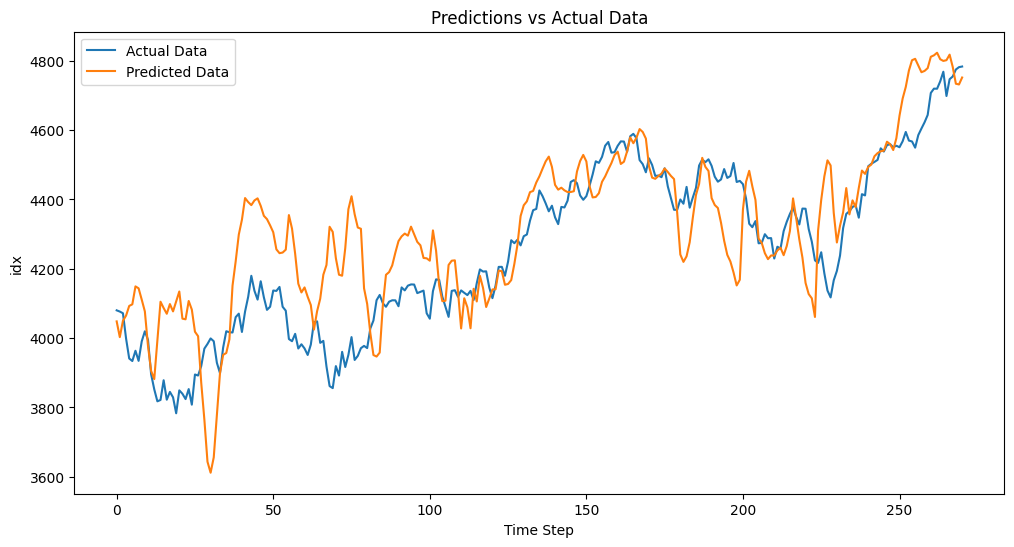

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model

# Load datasets
exogenous_data_path = '/kaggle/input/time-series-dataset/Exogenous_Data_1987_2024.xlsx'
training_data_path = '/kaggle/input/time-series-dataset/Training_Data_From_2000_To_2023 (1).xlsx'

exogenous_data = pd.read_excel(exogenous_data_path)
training_data = pd.read_excel(training_data_path)

# Drop 'Date' column and shift the target ('idx') by 1 day for correct prediction
data = training_data.drop('Date', axis=1)
data['idx'] = data['idx'].shift(-1)  # Shift 'idx' column by one day to predict the next day

# Drop the last row with NaN due to the shift
data = data.dropna()

# Normalize the data for training
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Split the dataset (95% training, 5% testing)
train_size = int(len(data_scaled) * 0.95)
train, test = data_scaled[:train_size], data_scaled[train_size:]

def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 1:])  # Input features (all except idx)
        y.append(dataset[i + time_step, 0])  # Target (idx column)
    return np.array(X), np.array(y)

# Set the time step (lookback window)
time_step = 30

# Create training and test datasets
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Define the LSTM-based model structure
def build_lstm_model(lstm_units, dropout_rate):
    num_features = X_train.shape[2]
    
    inputs = Input(shape=(time_step, num_features))

    # LSTM layers with Batch Normalization and Dropout
    x = LSTM(units=lstm_units, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)  # Increased Dropout for regularization
    
    x = LSTM(units=lstm_units)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)  # Increased Dropout for regularization

    # Output layer
    outputs = Dense(1)(x)

    # Build and compile the model
    model = Model(inputs, outputs)
    return model

# Hyperparameters
lstm_units = 128  # Number of LSTM units
dropout_rate = 0.3  # Increased Dropout rate to 0.3
learning_rate = 1e-4  # Learning rate
epochs = 50  # Number of epochs
batch_size = 64  # Batch size

# Build the LSTM model
model = build_lstm_model(lstm_units, dropout_rate)

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to stop training when validation loss is no longer improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Fit the model with early stopping and learning rate reduction
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# After training, make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_train = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))], axis=1))[:, 0]

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict)
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)

# Print performance metrics
print(f'Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}, Test MAE: {test_mae}')
print(f'Train R2: {train_r2}, Test R2: {test_r2}')

# Plot predictions vs actual data
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Data')
plt.plot(test_predict, label='Predicted Data')
plt.title('Predictions vs Actual Data')
plt.xlabel('Time Step')
plt.ylabel('idx')
plt.legend()
plt.show()


Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.3720 - val_loss: 0.4202 - learning_rate: 0.0010
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0338 - val_loss: 0.2570 - learning_rate: 0.0010
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0157 - val_loss: 0.0750 - learning_rate: 0.0010
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0101 - val_loss: 0.0246 - learning_rate: 0.0010
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0080 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0073 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0054 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0043 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0033 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 10/1

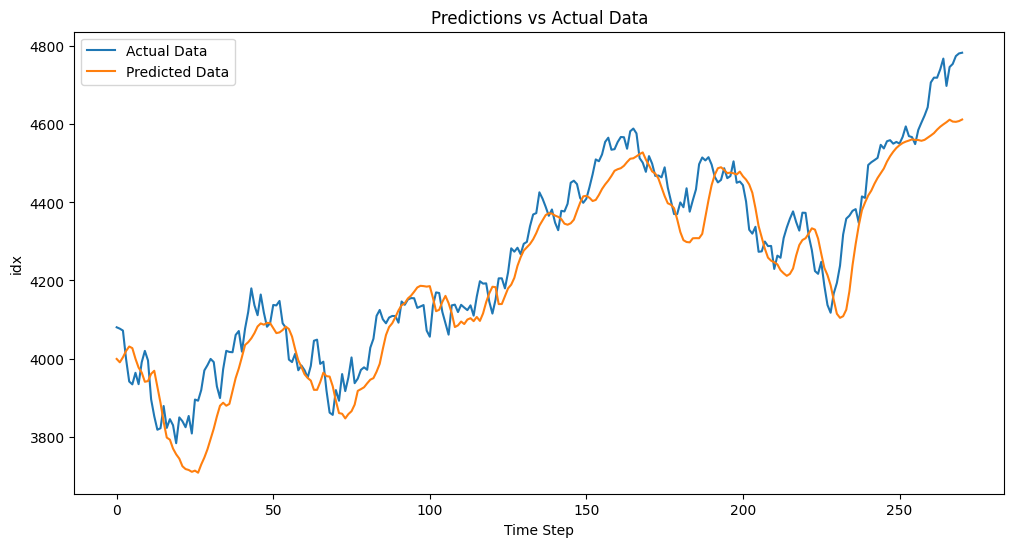

In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model

# Load datasets
exogenous_data_path = '/kaggle/input/time-series-dataset/Exogenous_Data_1987_2024.xlsx'
training_data_path = '/kaggle/input/time-series-dataset/Training_Data_From_2000_To_2023 (1).xlsx'

exogenous_data = pd.read_excel(exogenous_data_path)
training_data = pd.read_excel(training_data_path)

# Drop 'Date' column and shift the target ('idx') by 1 day for correct prediction
data = training_data.drop('Date', axis=1)
data['idx'] = data['idx'].shift(-1)  # Shift 'idx' column by one day to predict the next day

# Drop the last row with NaN due to the shift
data = data.dropna()

# Normalize the data for training
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Split the dataset (95% training, 5% testing)
train_size = int(len(data_scaled) * 0.95)
train, test = data_scaled[:train_size], data_scaled[train_size:]

def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 1:])  # Input features (all except idx)
        y.append(dataset[i + time_step, 0])  # Target (idx column)
    return np.array(X), np.array(y)

# Set the time step (lookback window)
time_step = 30

# Create training and test datasets
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Define the LSTM-based model structure
def build_lstm_model(lstm_units, dropout_rate):
    num_features = X_train.shape[2]
    
    inputs = Input(shape=(time_step, num_features))

    # Increased LSTM layers and units for better learning
    x = LSTM(units=lstm_units, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(units=lstm_units, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = LSTM(units=lstm_units)(x)
    x = BatchNormalization()(x)
    
    # Dropout layer
    x = Dropout(dropout_rate)(x)

    # Added Dense layers for improved learning
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    # Output layer
    outputs = Dense(1)(x)

    # Build and compile the model
    model = Model(inputs, outputs)
    return model

# Hyperparameters
lstm_units = 256  # Increased number of LSTM units
dropout_rate = 0.2  # Dropout rate remains same
learning_rate = 1e-3  # Increased learning rate for faster learning
epochs = 100  # Increased the number of epochs to allow more learning
batch_size = 64  # Keep batch size the same

# Build the LSTM model
model = build_lstm_model(lstm_units, dropout_rate)

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Fit the model with more epochs
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr],
    verbose=1
)

# After training, make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_train = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))], axis=1))[:, 0]

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict)
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)

# Print performance metrics
print(f'Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}, Test MAE: {test_mae}')
print(f'Train R2: {train_r2}, Test R2: {test_r2}')

# Plot predictions vs actual data
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Data')
plt.plot(test_predict, label='Predicted Data')
plt.title('Predictions vs Actual Data')
plt.xlabel('Time Step')
plt.ylabel('idx')
plt.legend()
plt.show()


Epoch 1/50
Train Loss: 0.25521114468574524, Test Loss (Backprop): 0.0012595433508977294
Epoch 2/50
Train Loss: 0.379885733127594, Test Loss (Backprop): 0.00035601932904683053
Epoch 3/50
Train Loss: 0.1617651879787445, Test Loss (Backprop): 0.0001686060131760314
Epoch 4/50
Train Loss: 0.06711287796497345, Test Loss (Backprop): 0.00013096760085318238
Epoch 5/50
Train Loss: 0.2515137195587158, Test Loss (Backprop): 0.00010306666081305593
Epoch 6/50
Train Loss: 0.2280934453010559, Test Loss (Backprop): 0.00010232813656330109
Epoch 7/50
Train Loss: 0.2617473006248474, Test Loss (Backprop): 9.172291174763814e-05
Epoch 8/50
Train Loss: 0.3411576449871063, Test Loss (Backprop): 5.8276324125472456e-05
Epoch 9/50
Train Loss: 0.2944977879524231, Test Loss (Backprop): 6.352232594508678e-05
Epoch 10/50
Train Loss: 0.31045907735824585, Test Loss (Backprop): 5.107065226184204e-05
Epoch 11/50
Train Loss: 0.1118689477443695, Test Loss (Backprop): 4.20309734181501e-05
Epoch 12/50
Train Loss: 0.208670958

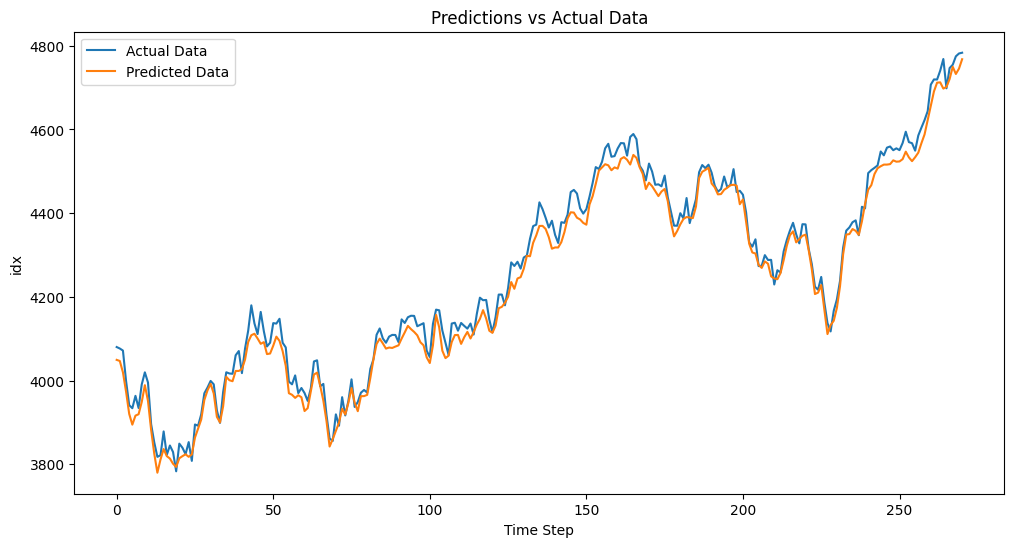

In [3]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model

# Load datasets
exogenous_data_path = '/kaggle/input/time-series-dataset/Exogenous_Data_1987_2024.xlsx'
training_data_path = '/kaggle/input/time-series-dataset/Training_Data_From_2000_To_2023 (1).xlsx'

exogenous_data = pd.read_excel(exogenous_data_path)
training_data = pd.read_excel(training_data_path)

# Drop 'Date' column and shift the target ('idx') by 1 day for correct prediction
data = training_data.drop('Date', axis=1)
data['idx'] = data['idx'].shift(-1)  # Shift 'idx' column by one day to predict the next day

# Drop the last row with NaN due to the shift
data = data.dropna()

# Normalize the data for training
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Split the dataset (95% training, 5% testing)
train_size = int(len(data_scaled) * 0.95)
train, test = data_scaled[:train_size], data_scaled[train_size:]

def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 1:])  # Input features (all except idx)
        y.append(dataset[i + time_step, 0])  # Target (idx column)
    return np.array(X), np.array(y)

# Set the time step (lookback window)
time_step = 30

# Create training and test datasets
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Define the LSTM-based model structure
def build_lstm_model(lstm_units, dropout_rate):
    num_features = X_train.shape[2]
    
    inputs = Input(shape=(time_step, num_features))

    # LSTM layers
    x = LSTM(units=lstm_units, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(units=lstm_units)(x)

    # Dropout for regularization
    x = Dropout(dropout_rate)(x)

    # Output layer
    outputs = Dense(1)(x)

    # Build and compile the model
    model = Model(inputs, outputs)
    return model

# Hyperparameters
lstm_units = 128  # Number of LSTM units
dropout_rate = 0.3  # Dropout rate
learning_rate = 1e-4  # Learning rate
epochs = 50  # Number of epochs
batch_size = 64  # Batch size

# Build the LSTM model
model = build_lstm_model(lstm_units, dropout_rate)

# Optimizer and loss function
optimizer = Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

# Custom training loop using GradientTape for minimizing test loss
@tf.function
def train_step(X_train_batch, y_train_batch, X_test, y_test):
    with tf.GradientTape() as tape:
        # Forward pass on training data
        predictions_train = model(X_train_batch, training=True)
        loss_train = loss_fn(y_train_batch, predictions_train)

        # Forward pass on test data
        predictions_test = model(X_test, training=False)
        loss_test = loss_fn(y_test, predictions_test)

    # Compute gradients based on test loss
    gradients = tape.gradient(loss_test, model.trainable_variables)

    # Update weights to minimize test loss
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss_train, loss_test

# Prepare test data for backpropagation (2023 data)
X_test_tf = tf.convert_to_tensor(X_test)
y_test_tf = tf.convert_to_tensor(y_test)

# Custom training loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Shuffle the training data for each epoch
    indices = np.random.permutation(len(X_train))
    X_train_shuffled, y_train_shuffled = X_train[indices], y_train[indices]

    # Training in batches
    for start in range(0, len(X_train), batch_size):
        end = start + batch_size
        X_train_batch = X_train_shuffled[start:end]
        y_train_batch = y_train_shuffled[start:end]

        # Convert batches to tensors
        X_train_batch_tf = tf.convert_to_tensor(X_train_batch)
        y_train_batch_tf = tf.convert_to_tensor(y_train_batch)

        # Perform one training step
        loss_train, loss_test = train_step(X_train_batch_tf, y_train_batch_tf, X_test_tf, y_test_tf)

    print(f"Train Loss: {loss_train.numpy()}, Test Loss (Backprop): {loss_test.numpy()}")

# After training, make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_train = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))], axis=1))[:, 0]

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict)
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)

# Print performance metrics
print(f'Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}, Test MAE: {test_mae}')
print(f'Train R2: {train_r2}, Test R2: {test_r2}')

# Plot predictions vs actual data
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Data')
plt.plot(test_predict, label='Predicted Data')
plt.title('Predictions vs Actual Data')
plt.xlabel('Time Step')
plt.ylabel('idx')
plt.legend()
plt.show()
